In [ ]:
import cv2
import torch
import config as cfg
from src.model.model_deeplabv3 import deeplabv3
from src.model.lightning_file import HumanSegmentation
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [ ]:
torch.cuda.empty_cache()

model = deeplabv3()
checkpoint = "../mlruns/163865829670612271/640abc12e9b2419f910196ffead7e2f8/artifacts/human-seg-epoch=9-validation_loss=0.01629.ckpt"
inference_model = HumanSegmentation.load_from_checkpoint(checkpoint_path=checkpoint, model=model)
inference_model.eval()
inference_model.to("cuda")

PID_Binary_Segmentation(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

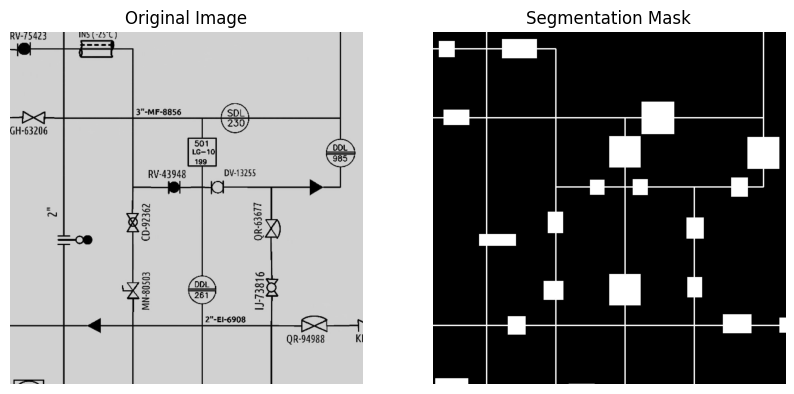

In [ ]:
image_path = "../data/"
mask_path = "../data/"

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Plot binary mask
plt.subplot(1, 2, 2)
plt.imshow(original_mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')

plt.show()

input_image = cfg.IMAGE_TRANSFORMS(original_image)
input_image = input_image.unsqueeze(0).to("cuda") # create a mini-batch as expected by the model

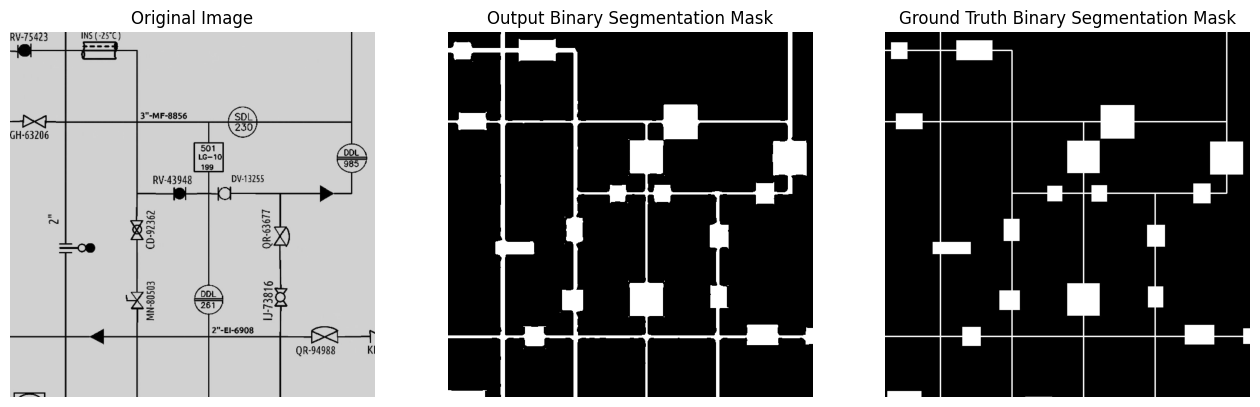

In [ ]:
# Get model output logits
logits = inference_model(input_image)['out'][0]  # Get the first item in the batch if in batch mode

# Apply sigmoid to get probabilities, then threshold to get binary mask
probabilities = torch.sigmoid(logits)
binary_mask = probabilities > cfg.THRESHOLD

# Convert binary mask to CPU and numpy array
binary_mask = binary_mask.squeeze().cpu().numpy()  # Remove channel dimension

# Convert the input image to a format that matplotlib can display
input_image_display = to_pil_image(original_image)  # Convert to PIL image

# Plot original image and binary mask
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(input_image_display)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(binary_mask, cmap="gray")
axes[1].set_title("Output Binary Segmentation Mask")
axes[1].axis("off")

axes[2].imshow(original_mask, cmap="gray")
axes[2].set_title("Ground Truth Binary Segmentation Mask")
axes[2].axis("off")

plt.show()

In [ ]:
# TODO: Overlay mask over image